# Multiple plotting of modules parameters, acquired by the flash test technique, after different treatments

### Introduction
This programm plots the module parameters versus the irradiance for various module treatment. The parameters are acquired using the flash test method.
<br/>
The module parameters, as well as the I/V curves, are stored in .csv files which names obeys the following format:
- UUUdddd_ddddW_Td.csv with U=[A-Z,-,_] and d=[1-9]. We have:
  - UUUdddd_dddd is the module type the number of U is unlimited  and the  the number of digits d is limited to 50
  - ddddW is the irradiande in W/m^2. The number of digits d must be equal to 4.
  - Td is the treatment label. The numer of digit d is equal to 1.
These files are stored in the *data_folder* and all its sub folders
and can be parsed by the function *data_parsing(filepath, parse_all=True)*

### Description
</br></br>
The program:
1. Interactevelly defines the *data_folder* where *data_folder* must be locate is the users home directory.
2. Recursivelly builds the list of all .csv file located in the folder *data_folder* and its sub-folders.
3. Interactivelly selects the list modules to be analysed and build the dataframe *df_meta* containing all the data necessary to the plotting of the modules parameters
4. Interactivelly defines the list of tuple [(T(i),T(j))], where T(i) stands for the ieme treatment.
5. Interactivelly convert the symbolic items T(i) into the name of the treatment.
6. For *n_params* parameters interactivelly sectected plots the *n_params* the parameters relative variation between two treatments T(k) and T(h):
    
   $$100\frac{{Para{m_i}(Irradiance(n);T(h),module(m)) - Para{m_i}(Irradiance(n);T(k),module(m))}}{{Para{m_i}(Irradiance(n);T(k),module(m))}}$$
   
### Module description
   
The program relies on the module *PVcharacterization_Utils* containig the following libraries:
1. PVcharacterization_GUI 
    - select_items
    - select_files
    - select_data_dir
    - input_treatment_labels
2. PVcharacterization_flashtest 
    - read_flashtest_file
    - df2sqlite
    - parse_filename
    - sieve_files
    - build_files_database
    - build_metadata_dataframe
    - assess_path_folders
    - input_treatment_labels
    - pv_flashtest_pca
3. PVcharacterization_global 
    - DEFAULT_DIR (Path.home())
    - DATA_BASE_NAME
    - DATA_BASE_TABLE_FILE
    - DATA_BASE_TABLE_EXP
    - USED_COLS
    - PARAM_UNIT_DIC
    - IRRADIANCE_DEFAULT_LIST
    - TREATMENT_DEFAULT_LIST
4. PVcharacterization_image (not used)
    - read_electolum_file
    - py2gwyddion
    - crop_image
5. PVcharacterization_plot
    - plot_params
    - init_plot_diff 
    - plot_params_diff
    - construct_x_y
    
### Nomenclature:
 - module-type (mod): ex. QCELL-2739, QCELLS901719162417702739
 - parameters (param): ex. Pmax, Voc, Isc, Fill Factor, Rseries
 - irradiance (irr): irradiance in W/m^2 
 - treatment (trt): treatment type T0, T1, T2,T2,...

In [1]:
''' 
    Creation: 2021.09.13
    Last update: 2021.10.11

    User specific paths definition

'''
# Local imports 
import PVcharacterization_Utils as pv

data_folder = pv.assess_path_folders()
df_files_descp = pv.build_files_database(data_folder)

130 files was detected.
df_files_descp and the data base table PV_descp in C:\Users\franc\PVcharacterization_files\pv.db are built


In [2]:
''' Creation: 2021.09.13
    Last update: 2021.09.20
    
    df_meta dataframe building from selected files in database DATA_BASE_NAME
    
'''
# Local imports
import PVcharacterization_Utils as pv

df_meta = pv.build_metadata_dataframe(df_files_descp,data_folder)
df_meta.describe()

,Pmax,Fill Factor,Voc,Isc,Rseries,Rshunt,Vpm,Ipm,irradiance
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,204.864295,0.789550,46.281472,5.617710,0.830307,650.929355,38.857474,5.284183,600.000000
std,100.273620,0.016852,6.542126,2.688848,0.494182,570.529946,5.216199,2.543933,283.936886
min,46.907900,0.751430,36.247500,1.543070,0.321700,1.861660,31.046500,1.410720,200.000000
25%,130.887750,0.781315,39.238000,3.564320,0.516142,271.873750,33.291150,3.322157,400.000000
50%,204.178500,0.788855,50.235650,5.394435,0.658945,541.725000,41.316450,5.025860,600.000000
75%,293.255750,0.803415,52.405675,7.999500,0.999607,796.558250,43.862600,7.632985,800.000000
max,376.158000,0.817790,53.415300,10.423200,2.458360,2950.010000,44.846900,9.886150,1000.000000


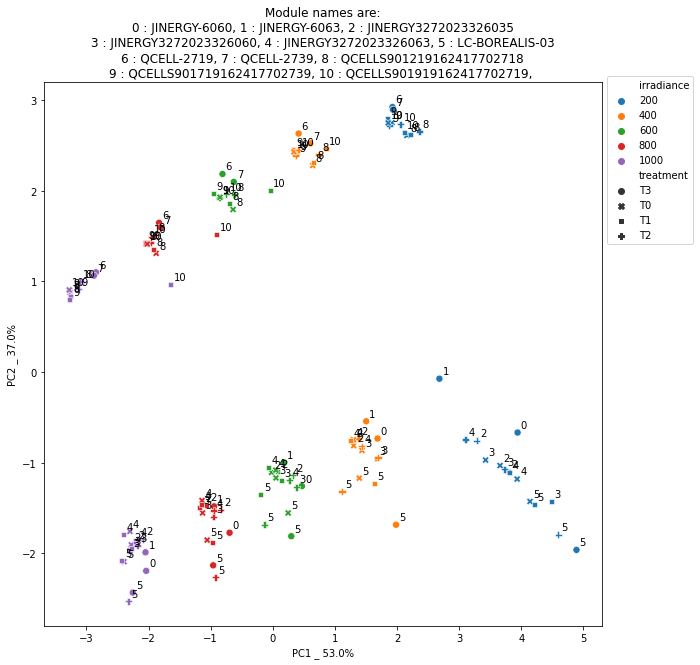

In [3]:
pv.pv_flashtest_pca(df_meta)

In [ ]:
''' Creation: 2021.10.03
    Last update: 2021.10.09
    
    Interactive choice of the treatment differences
    
    ''' 
# Local imports
import PVcharacterization_Utils as pv

list_diff = pv.init_plot_diff(df_meta)
dic_trt_meaning = pv.input_treatment_labels(list_diff)
#list_params = ['Pmax','Voc','Isc','Fill Factor','Rseries','bidon','trarmiz']
#list_diff = []
pv.plot_params_diff(df_meta,list_diff,None,dic_trt_meaning)


In [ ]:
''' Creation: 2021.09.19
    Last update: 2021.10.14
    
    Plotting of I/V curves.
    
    ''' 

# Local imports
import PVcharacterization_Utils as pv

irr_select = [1000]
name_select = ["JINERGY3272023326035",]
trt_select = ["T0","T1","T2"]

pv.plot_iv_curves(irr_select,name_select,trt_select,data_folder)